In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from types import SimpleNamespace
import datetime as dt

P = SimpleNamespace()
P.data = "../data"
CRS_DEG = 'EPSG:4326'
CRS_M = 'EPSG:3857'

# Boundaries

### US state FIPS codes
Obtained from https://transition.fcc.gov/oet/info/maps/census/fips/fips.txt

In [3]:
state_fips = pd.read_csv(P.data + '/map/state_fips.csv').set_index('state')['fips']
state_fips.head(2)

state
ALABAMA    1
ALASKA     2
Name: fips, dtype: int64

## Counties layer

### Load SVI data

In [4]:
svi_county = gpd.read_file(P.data + '/map/svi_county.gpkg')

# Storm path and region of interest

In [5]:
miny, minx = 27.447111954239862, -93.84508368683872
maxy, maxx = 33.62805867758481, -85.17760382903103

storm_line = gpd.read_file(P.data + '/hurricane/ida_path/line').to_crs(CRS_DEG)
storm_line2 = gpd.read_file(P.data + '/hurricane/nicho_path/AL142021_lin.shp').to_crs(CRS_DEG)

storm_pts = gpd.read_file(P.data + '/hurricane/ida_path/points').to_crs(CRS_DEG)
storm_pts2 = gpd.read_file(P.data + '/hurricane/nicho_path/AL142021_pts.shp').to_crs(CRS_DEG)

storm_radii = gpd.read_file(P.data + '/hurricane/ida_path/radii').to_crs(CRS_DEG)
storm_radii2 = gpd.read_file(P.data + '/hurricane/nicho_path/AL142021_radii.shp').to_crs(CRS_DEG)

us_counties = gpd.read_file(P.data + '/map/us_county/cb_2018_us_county_500k.shp').cx[minx:maxx, miny:maxy]

In [6]:
us_states = (us_counties.groupby('STATEFP')['geometry'].apply(lambda x: x.unary_union)
             .reset_index().set_crs(CRS_DEG)
             .assign(fips = lambda df: df.pop('STATEFP').astype(int))
             .merge(state_fips.reset_index(), on='fips'))

In [7]:
import matplotlib.patheffects as pe
from shapely.geometry import box
import matplotlib as mpl

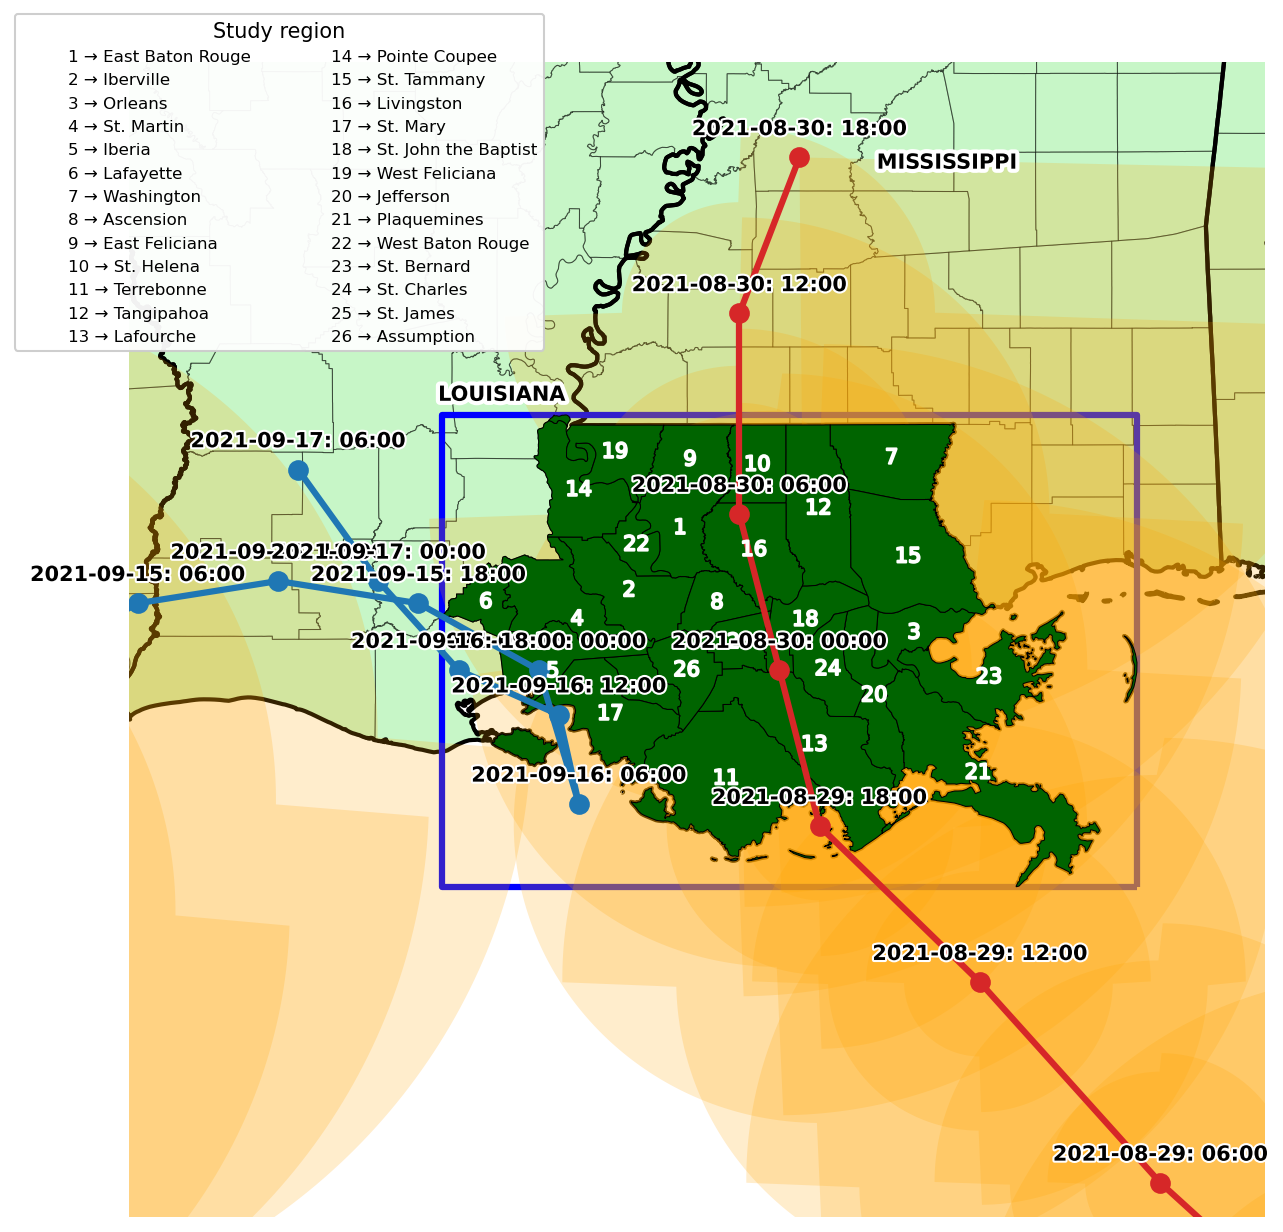

In [8]:
miny, minx = 27.447111954239862, -93.84508368683872
maxy, maxx = 32.62805867758481, -88.17760382903103

fig, ax = plt.subplots(figsize=(10, 10), dpi=150)
plt.axis("off")
plt.xlim([minx,maxx])
plt.ylim([miny,maxy])
us_counties.plot(ax=ax, facecolor='lightgreen', alpha=0.5, linewidth=0.5, edgecolor='k')
us_states.plot(ax=ax, facecolor='none', edgecolor='k', linewidth=2)
(gpd.GeoSeries([box(*svi_county.unary_union.bounds)], crs=CRS_DEG)
 .plot(ax=ax, facecolor='none', edgecolor='b', linewidth=3))


storm_radii.plot(ax=ax, facecolor='orange', alpha=0.2)
storm_radii2.plot(ax=ax, facecolor='orange', alpha=0.2)

for _, r in us_states.iterrows():
    # only show Lousiana and Mississippi
    if r.state not in ['LOUISIANA', 'MISSISSIPPI']:
        continue
    x, y = r.geometry.centroid.coords[0]
    if r.state == 'LOUISIANA':
        y += 0.05
    else:
        y -= 0.05
    ax.text(x, y, r['state'], ha='center', fontweight=700,
            path_effects=[pe.withStroke(linewidth=4, foreground='w')])
    

svi_county.plot(ax=ax, color='darkgreen', edgecolor='k', linewidth=0.5)
for i, r in svi_county.reset_index().iterrows():
    ax.text(*r.geometry.centroid.coords[0], str(i+1), ha='center', va='center', fontsize=10,
            color='w', path_effects=[pe.withStroke(linewidth=1, foreground='w')])
    

storm_line.plot(ax=ax, color='C3', linewidth=3)
storm_pts.plot(ax=ax, markersize=80, color='C3')

storm_line2.plot(ax=ax, color='C0', linewidth=3)
storm_pts2.plot(ax=ax, markersize=80, color='C0')


for i, r in storm_pts.cx[minx:maxx, miny:maxy].iterrows():
    label = (dt.datetime.strptime(str(int(r.YEAR)) + r.MONTH + str(int(r.DAY)) + r.HHMM, 
                                  '%Y%m%d%H%M').strftime('%Y-%m-%d: %H:00'))
    x,y = r.geometry.coords[0]
    ax.text(x, y + 0.1, label, fontweight=600, ha='center',
            path_effects=[pe.withStroke(linewidth=2, foreground='w')])

for i, r in storm_pts2.cx[minx:maxx, miny:maxy].iterrows():
    label = (dt.datetime.strptime(str(int(r.YEAR)) + r.MONTH + str(int(r.DAY)) + r.HHMM, 
                                  '%Y%m%d%H%M').strftime('%Y-%m-%d: %H:00'))
    x,y = r.geometry.coords[0]
    ax.text(x, y + 0.1, label, fontweight=600, ha='center',
            path_effects=[pe.withStroke(linewidth=2, foreground='w')])

# two columns legend
ax.legend([mpl.patches.Rectangle((0, 0), 0, 0.1, fill=False, edgecolor='none', visible=False) 
           for i in range(svi_county.shape[0])], [f'{i+1} → {x}' for i, x in enumerate(svi_county.NAME)],
          title='Study region', framealpha=0.95, loc=(-0.1, 0.75), ncol=2, fontsize = 8);

plt.savefig('../figs/background.pdf')
plt.savefig('../figs/background.png', dpi=300)

In [9]:
# generate the svi_tract
census_tract = gpd.read_file(P.data + '/map/tl_2020_22_tract.shp').to_crs(CRS_DEG)
census_tract.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,22,103,040805,22103040805,408.05,Census Tract 408.05,G5020,S,3062293,2656917,+30.2135248,-089.7956358,"POLYGON ((-89.82509 30.21614, -89.82459 30.216..."
1,22,103,040306,22103040306,403.06,Census Tract 403.06,G5020,S,4924945,27388,+30.3906947,-090.0970210,"POLYGON ((-90.11626 30.40305, -90.11620 30.403..."
2,22,103,040607,22103040607,406.07,Census Tract 406.07,G5020,S,11750546,606591,+30.4443292,-090.0966286,"POLYGON ((-90.11764 30.43771, -90.11693 30.438..."
3,22,103,040205,22103040205,402.05,Census Tract 402.05,G5020,S,54596733,640148,+30.5496880,-090.1033212,"POLYGON ((-90.14862 30.55694, -90.14844 30.556..."
4,22,103,040713,22103040713,407.13,Census Tract 407.13,G5020,S,25554446,605911,+30.3472476,-089.7810806,"POLYGON ((-89.81194 30.36872, -89.81174 30.368..."


In [10]:
svi_index = pd.read_csv(P.data + '/map/Louisiana.csv') 
svi_index['FIPS'] = svi_index['FIPS'].astype(str).str.zfill(11)
svi_index.head()

,ST,STATE,ST_ABBR,STCNTY,COUNTY,FIPS,LOCATION,AREA_SQMI,E_TOTPOP,M_TOTPOP,...,EP_ASIAN,MP_ASIAN,EP_AIAN,MP_AIAN,EP_NHPI,MP_NHPI,EP_TWOMORE,MP_TWOMORE,EP_OTHERRACE,MP_OTHERRACE
0,22,Louisiana,LA,22001,Acadia,22001960101,"Census Tract 9601.01, Acadia Parish, Louisiana",8.816507,3615,381,...,0.0,1.2,0.0,1.2,0.0,1.2,3.5,3.5,0.0,1.2
1,22,Louisiana,LA,22001,Acadia,22001960102,"Census Tract 9601.02, Acadia Parish, Louisiana",9.443575,2333,636,...,0.0,1.8,0.0,1.8,0.0,1.8,0.8,1.9,0.0,1.8
2,22,Louisiana,LA,22001,Acadia,22001960201,"Census Tract 9602.01, Acadia Parish, Louisiana",70.639603,3200,424,...,0.0,1.3,0.0,1.3,0.0,1.3,2.3,2.8,0.0,1.3
3,22,Louisiana,LA,22001,Acadia,22001960202,"Census Tract 9602.02, Acadia Parish, Louisiana",65.101248,2301,226,...,0.0,1.8,0.0,1.8,0.0,1.8,0.0,1.8,0.0,1.8
4,22,Louisiana,LA,22001,Acadia,22001960300,"Census Tract 9603, Acadia Parish, Louisiana",90.197262,3491,662,...,0.0,1.2,0.0,1.2,0.0,1.2,0.3,0.6,0.0,1.2


In [11]:
svi_tract =  census_tract.merge(svi_index, left_on='GEOID', right_on='FIPS')

In [12]:
# lower case the column names
svi_tract.columns = svi_tract.columns.str.lower()

In [15]:
# join with the study region
svi_tract = svi_tract[svi_tract['countyfp'].isin(svi_county['COUNTYFP'])]

In [17]:
svi_tract.reset_index(drop=True, inplace=True)

In [25]:
svi_tract.to_file(P.data + '/map/svi_tract.gpkg')

<Axes: >

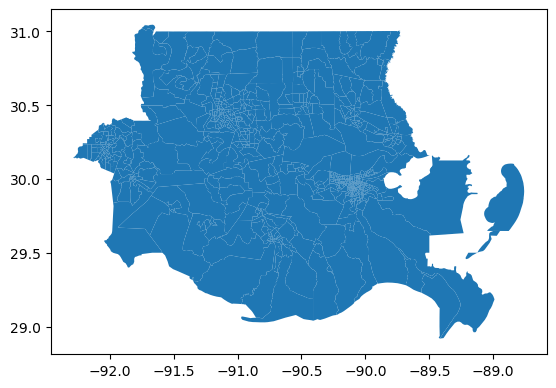

In [26]:
svi_tract.plot()